# LAB 7: Error analysis

Objectives
* Construct a  linear text classifier using SGDClassifier
* Evaluate its performance and categorize the errors that it makes
* Eaxmine model's coefficients and decision function values
* Interpret model results using LIME

In [2]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [3]:
train = pd.read_parquet("s3://ling583/lab7-train.parquet", storage_options={"anon":True})
test = pd.read_parquet("s3://ling583/lab7-test.parquet", storage_options={"anon":True})

In [4]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [5]:
# we didnt have to import spacy since what we need gets brought in through this pickle
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [6]:
sgd

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.75, min_df=5,
                                 preprocessor=<cyfunction identity at 0x7f68cedeb2b0>,
                                 tokenizer=<function tokenize at 0x7f689c38ca60>)),
                ('tfidftransformer', TfidfTransformer()),
                ('sgdclassifier', SGDClassifier())])

In [7]:
predicted = sgd.predict(test["text"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        GJOB       0.97      0.94      0.96       573
        GPOL       0.94      0.96      0.95      1853
        GSPO       1.00      0.99      1.00      1410
        GVIO       0.92      0.91      0.92       928

    accuracy                           0.96      4764
   macro avg       0.96      0.95      0.96      4764
weighted avg       0.96      0.96      0.96      4764



---

## Confusion matrix
How often labels are confused with each other
Rows are the correct labels
Columns are the predicted labels

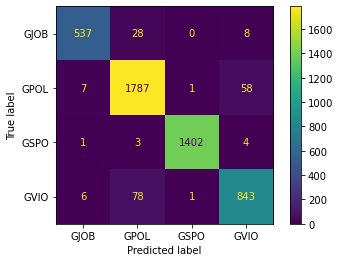

In [8]:
plot_confusion_matrix(sgd, test["text"], test["topics"])

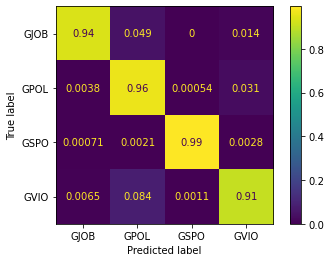

In [9]:
# Normalize by the rows to see percentages
plot_confusion_matrix(sgd, test["text"], test["topics"], normalize='true')

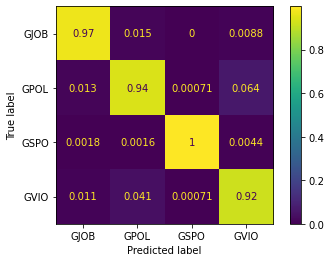

In [10]:
# Normalize by the columns
plot_confusion_matrix(sgd, test["text"], test["topics"], normalize='pred')

**TO DO:**Summarize this section: what does the confusion matrix tell us about our classifier?

The confusion matrices indicate that the model has some issues distinguishing between political and war related articles. 
The issues with war and political articles goes both ways, with war articles being tagged as political and political articles being tagged as war. This is likely due to the conflation of these two topivc; they are very interrelated and are often discussed together. 

There are also issues, though to a lesser extent, with differentiating politics and employment. This issue seems to be primarily in one direction, with employment articles being predicted as political. This is likely due to these articles disussing employee unions and legal regulations pertaining to employment. As with the war and politics, it is common to see disussion of politics within discussion of employment, though discussion of politics does not necessarily lead to discussion of employment. 

----

## Errors

In [39]:
#3 create a subset where the label was violence/civil war and the prediction was politics
err = test[(test['topics']=='GVIO')&(predicted=='GPOL')]
len(err)

78

In [32]:
err['text'].iloc[0]
# doesn't seem to be about war, so this is likely an issue with the data, not our model

"Documents missing on chemicals in Gulf - report. The U.S. Defence Department said nearly all the classified documents recording incidents of chemical weapons use during the Gulf war are missing despite an exhaustive search, the New York Times reported on Friday. The paper said copies of the logs were kept in safes at two U.S. locations, but a new report from the Defence Department indicates only 36 pages out of an estimated 200 have been found in a search by its investigators. The missing logs include those for eight days in March 1991 when U.S. troops unknowingly blew up chemical weapons in an Iraqi arms dump, the paper said. Those logs, which were maintained for Gen. Norman Schwarzkopf, were first reported missing in December. Friday's paper said the new report heightens speculation about a cover-up or criminal incompetence within the Defence Department, which had denied the existence of such records before agreeing last year to release them to a veterans' group. It said the logs we

In [33]:
err['text'].iloc[1]
# doesn't seem to be about war, so this is likely an issue with the data, not our model

'China to approve Shell petchem joint venture soon. China\'s executive vice chairman of state planning Ye Qing on Friday said he expected the Chinese authorities soon to approve a major joint venture project to build a petrochemical plant with Shell in Guangdong province. "I saw the managing director of Shell two days ago and I told him that I personally and the state commission will approve this project very soon," Ye told reporters in Paris at a press conference following an International Energy Agency ministerial meeting. The project to build a petrochemical plant is a joint venture with the state China National Offshore Oil Corporation and has been under discussion since 1971 Ye said the plants was expected to produce 85 million tonnes a year of ethylene, having been raised from previous plans for 45 million tonnes of annual capacity. Ye also said that plans for a refinery at the same site remained on hold. "To ensure a better return for the project we have decided not to build a r

In [34]:
err['text'].iloc[2]

'Australian Jews scan Swiss Holocaust bank list. Hundreds of relatives of Jewish Holocaust victims living in Australia could be eligible for funds in Swiss banks after the publication of more than 2,000 pre-1945 accounts, Jewish officials said on Wednesday. While only four Australian names were on the list, Australia boasts the world\'s fourth largest Jewish population, due to large scale post-World War Two migration. "There are more Jews of Polish decent living in Australia than there are Jews living in Poland," said Jeremy Jones, spokesman for the Executive Council of Australian Jewry. "There could potentially be hundreds (of relatives) on this list, but we do not believe that this list is comprehensive or exhaustive. This is the list from the Swiss banks: it is not a list discovered by any independent audit," Jones told Reuters. The Swiss Bankers Association took out a double-page advertisement in The Australian national newspaper, listing more than 2,000 pre-1945 accounts, includin

In [41]:
# is about war, predicted politics
for t in err['text'].sample(10):
    print(t)
    print()

Tuzla mayor warns Germany against refugee return. German plans to forcibly repatriate thousands of refugees to former Yugoslavia will exacerbate tensions in Bosnia and cause untold suffering, the mayor of the northern Bosnian city of Tuzla said on Wednesday. Selim Beslagic appealed to state governments to reconsider their decision to start the compulsory return of some of the 320,000 refugees now living in Germany, warning that Bosnia could not cope with a flood of refugees. "You cannot solve the problem by simply chasing people out," Beslagic said at a news conference in Bonn. "We want the refugees to return to Bosnia too, but it has to be carefully prepared to avoid further tensions." Germany's 16 federal states ignored international criticism and decided last month to begin sending home Bosnians who took refuge here from the Balkan war. States such as Bavaria and Berlin, whose budgets have been hit by costly support payments, have taken a hard line. Bavaria's interior minister Guent

In [42]:
#3 create a subset where the label was politics and the prediction was violence/civil war
err2 = test[(test['topics']=='GPOL')&(predicted=='GVIO')]
len(err)

78

In [44]:
# is politics, predicted war
for t in err2['text'].sample(10):
    print(t)
    print()

Jewish group uses Internet in Swiss bank move. A prominent Jewish group on Tuesday put the names of 1,500 Holocaust victims and survivors who deposited money in Swiss bank accounts on the worldwide computer Internet in a bid to help them or their heirs recover the money. The Simon Wiesenthal Centre in Los Angeles, named after the famous Nazi hunter, announced that it had created a special World Wide Web page at http://www.wiesenthal.com to publicise the names. Rabbi Marvin Hier, founder and dean of the centre, told a news conference he hoped putting the names on the Internet would lead to the heirs of the depositors, and perhaps even the depositors themselves if they were still alive, lodging claims against Swiss Bank Corp. Hier said the list was supplied to the centre by Swiss Bank Corp., one of three major Swiss banks being sued by American Jews who believe their money, or the money of their dead relatives to which they are entitled, is being held by those banks. The other two Swiss 

**TO DO:** Based on your error analysis, what are some of the classifier's strengths and weaknesses? What might we do to improve it?

It seems like the classifier has issues identifying the nuances of human language and relies on key words within an articleto determine its tags. There are also some limitations within the data, as shown above, there are fairly significant number of cases where the articles are arguably tagged incorrectly in the source. 

In the "Source tagged as war, classified as politics" section, there seem to be a lot of articles regarding the politics surrounding and resulting from war. Our classifier correctly tagged these as politics but the source data has them tagged as war, likely because the issues being discussed at the political level are about war and the numerous keywords like "war", "Holocaust", "missiles", and "military" likely swing the tone of the article towards war.

In the "Source tagged as politics, classified as war" section, there seems to be a similar trend, where war and politics are conflated within the article which makes it difficult for our classifier to tell them apart. In this case I found a number of war related keywords that may have caused them to be classified as such. These include "kil(er, ed)", "guns", "troops", "ceasefire", and (guerrilla) war". 

The primary issue seems to surround keywords regarding war, which tripped up both our classifier and the originators of the data. 